In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import seaborn as sns
sns.set(font= "Kaiti",style="ticks",font_scale=1.4)
import pandas as pd
pd.set_option("max_colwidth", 200)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import anndata as ad
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
def load_VAE():
    autoencoder = VAE(
        num_genes=19423, 
        device='cuda',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('/home/workplace/cfDiffusion/checkpoint/VAE/wot/model_seed=0_step=800000.pt'))
    return autoencoder

real data

In [12]:
tmp = sc.read_h5ad('/home/workplace/cfDiffusion/dataset/WOT_dataset/WOT_filted_data.h5ad')

In [14]:
tmp.obs['period'].cat.categories

Index(['D0', 'D0.5', 'D1', 'D1.5', 'D10', 'D10.5', 'D11', 'D11.5', 'D12',
       'D12.5', 'D13', 'D13.5', 'D14', 'D14.5', 'D15', 'D15.5', 'D16', 'D16.5',
       'D17', 'D17.5', 'D18', 'D2', 'D2.5', 'D3', 'D3.5', 'D4', 'D4.5', 'D5',
       'D5.5', 'D6', 'D6.5', 'D7', 'D7.5', 'D8', 'D8.25', 'D8.5', 'D8.75',
       'D9', 'D9.5', 'DiPSC'],
      dtype='object')

In [15]:
tmp.shape

(254197, 19423)

In [4]:
adata = sc.read_h5ad('/home/workplace/cfDiffusion/dataset/WOT_dataset/WOT_filted_data.h5ad')
adata = adata[np.where(np.in1d(adata.obs['period'], ['D0','D0.5','D1','D1.5','D2','D2.5','D3','D4.5','D5','D5.5','D6','D6.5','D7','D7.5','D8']))[0]]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata = adata[np.where(adata.obs['period'].values.isnull()==0)[0]]#[::5]

# celltype = adata.obs['period']
cell_data = adata.X
cell_data.shape

(82920, 19423)

In [5]:
114396/31

3690.1935483870966

generated data

In [6]:
cell_gen_all = []
# gen_class = []
cato = ['D0', 'D0.5', 'D1', 'D1.5', 'D2', 'D2.5', 'D3', 'D4.5', 'D5', 'D5.5', 'D6', 'D6.5',
        'D7', 'D7.5', 'D8']
index2 = [i for i in range(15)]
for i in index2:
    npyfile=np.load(f'/home/workplace/cfDiffusion/generation/wot/cell{i}_cache5.npy',allow_pickle=True)
    length = min(adata[adata.obs['period']==cato[i]].X.shape[0], 9000)
    cell_gen_all.append(npyfile[:int(length)])#.squeeze(1)

    # gen_class+=['gen '+cato[i]]*int(length)

cell_gen_all = np.concatenate(cell_gen_all,axis=0) #(11401, 128)

autoencoder = load_VAE().cuda()
cell_gen_all = autoencoder(torch.tensor(cell_gen_all).cuda(),return_decoded=True).cpu().detach().numpy()

full_data = np.concatenate((cell_data, cell_gen_all), axis=0)
print(full_data.shape) #(11401, 18996)

full_data = ad.AnnData(full_data, dtype=np.float32)
full_data.obs_names = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen_all.shape[0])]

(165840, 19423)


In [7]:
full_data = np.concatenate((cell_data, cell_gen_all), axis=0)
print(full_data.shape) #(11401, 18996)

full_data = ad.AnnData(full_data, dtype=np.float32)
full_data.obs_names = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen_all.shape[0])]

(165840, 19423)


In [8]:
adata = full_data
sc.tl.pca(adata, svd_solver='arpack')# svd_solver 

In [9]:
real = adata[adata.obs_names=='true_Cell'].obsm['X_pca']
sim = adata[adata.obs_names=='gen_Cell'].obsm['X_pca']

data = np.concatenate((real,sim),axis=0)
label = np.concatenate((np.ones((real.shape[0])),np.zeros((sim.shape[0]))))

print(data.shape, label.shape)
##split the data
X_train,X_val,y_train,y_val = train_test_split(data, label,
                                               test_size = 0.25,random_state = 1)

print("X_train.shape :",X_train.shape)
print("X_val.shape :",X_val.shape)

(165840, 50) (165840,)
X_train.shape : (124380, 50)
X_val.shape : (41460, 50)


In [10]:
## use random forest to classify the real data and generated data
rfc1 = RandomForestClassifier(n_estimators = 1000, 
                              max_depth= 5,      
                              oob_score=True,
                              class_weight = "balanced",
                              random_state=1)
rfc1.fit(X_train,y_train)
## accuracy
rfc1_lab = rfc1.predict(X_train)
rfc1_pre = rfc1.predict(X_val)
print("OOB score of random forest:",rfc1.oob_score_)
print("accuracy in training set:",accuracy_score(y_train,rfc1_lab))
print("accuracy in validation set:",accuracy_score(y_val,rfc1_pre))

OOB score of random forest: 0.6290480784692073
accuracy in training set: 0.6356890175269336
accuracy in validation set: 0.6281476121562952


plot ROC curve

findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font family 'Kaiti' not found.
findfont: Font f

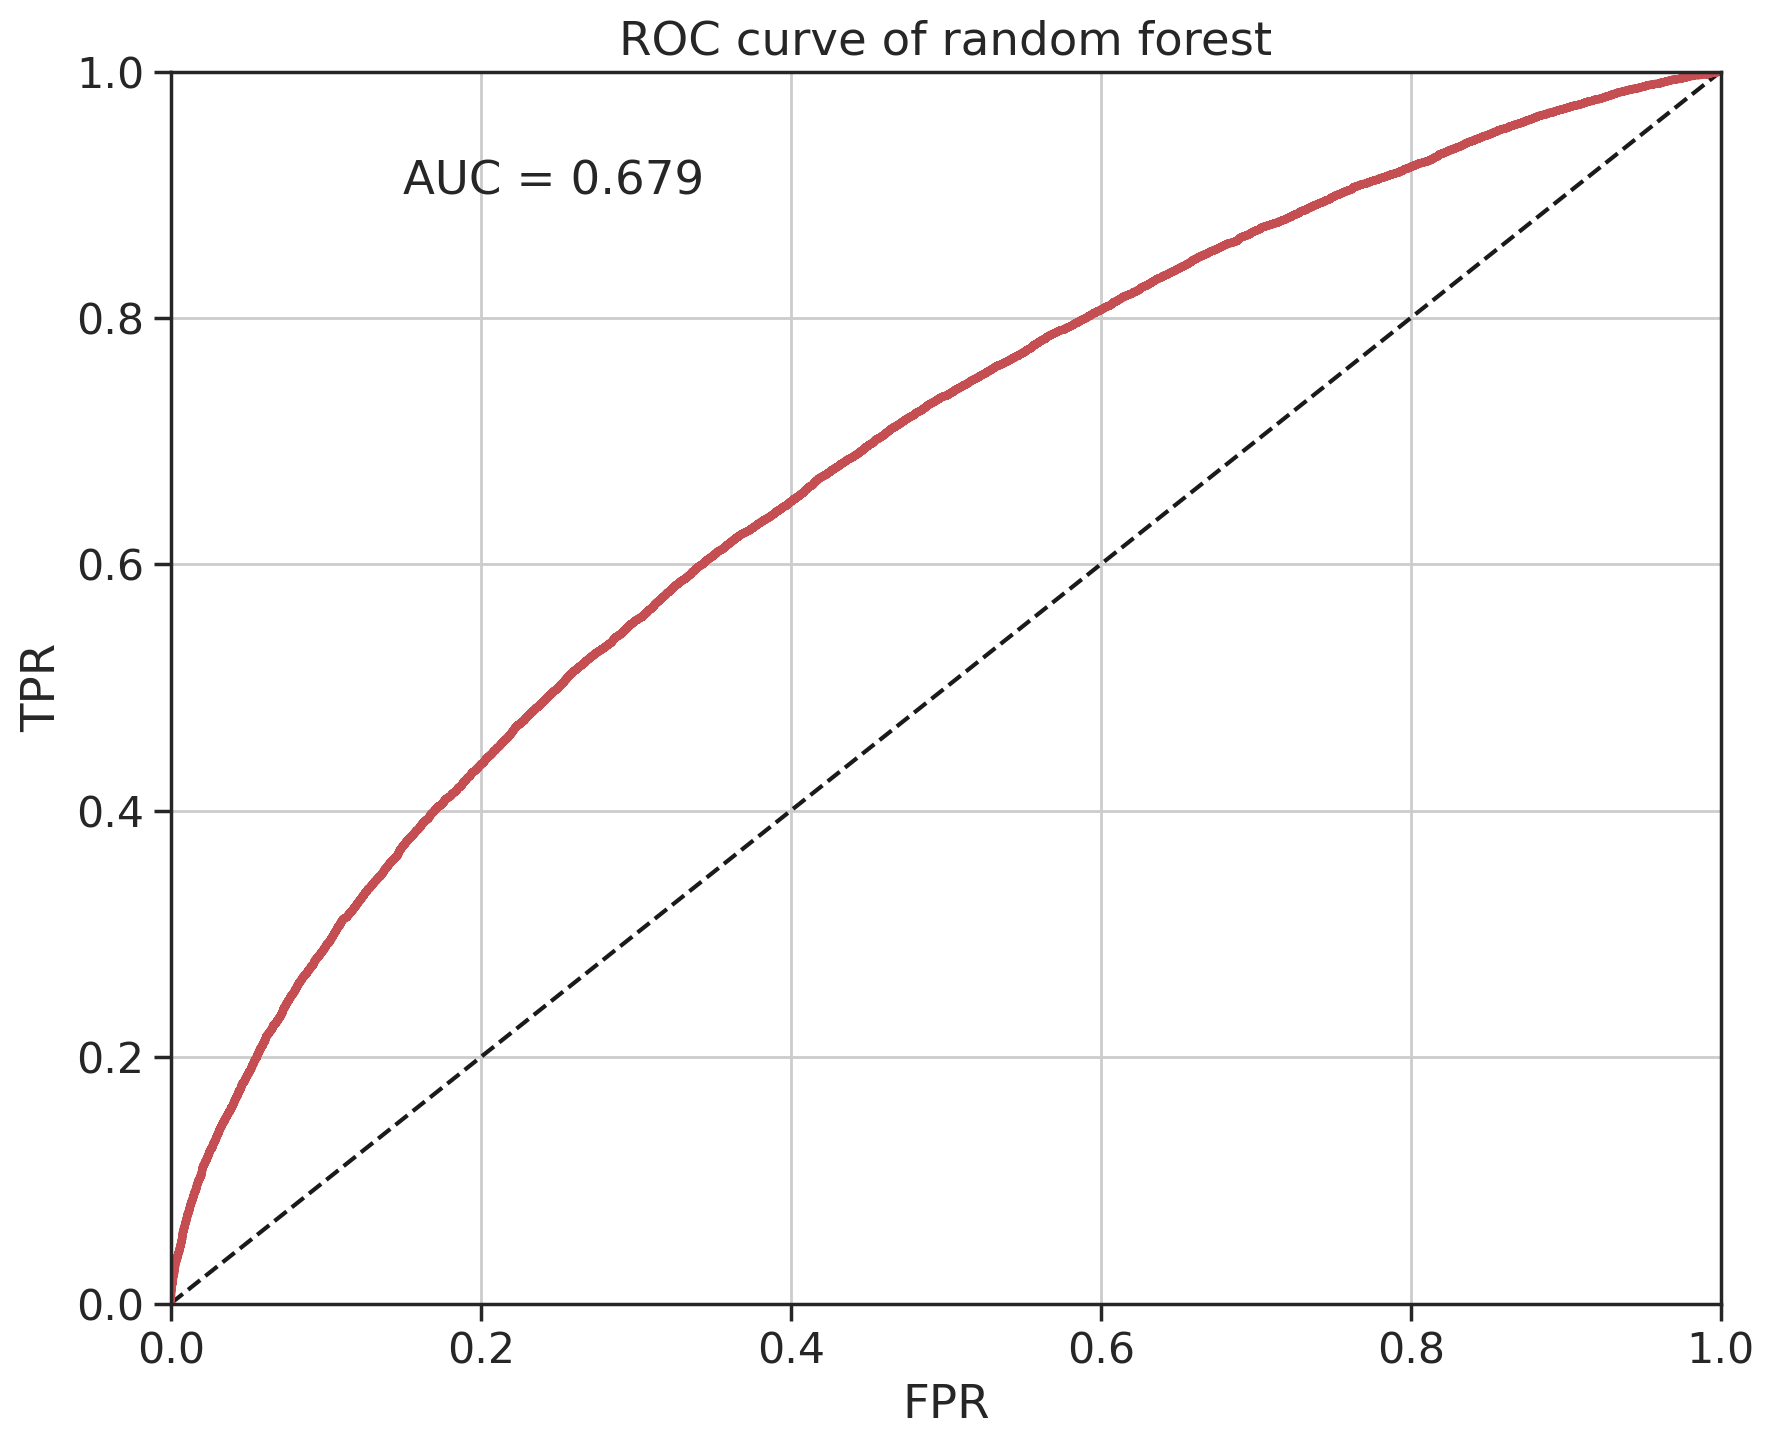

In [11]:
pre_y = rfc1.predict_proba(X_val)[:, 1]
fpr_Nb, tpr_Nb, _ = roc_curve(y_val, pre_y)
aucval = auc(fpr_Nb, tpr_Nb)    # 计算auc的取值
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Nb, tpr_Nb,"r",linewidth = 3)
plt.grid()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title("ROC curve of random forest")
plt.text(0.15,0.9,"AUC = "+str(round(aucval,4)))
# plt.show()
plt.savefig('./random_forest.svg')